# Introduction

### Welcome to my first ever Machine Learning project/Kaggle Competition!

In this notebook we'll do some easy data visualizations and feature engineering before applying different machine learning algorithms like Logistic Regression, Random Forest, Support Vector Machines and more. We're also using a Neural Network using Keras and Tensorflow with a Keras-Tuner for hyperparameter optimization. For better understanding of the dataset and algorithms we'll use a PCA and ROC-Curves.

**If you have any suggestions on how to improve this notebook please let me know!**

# 1. Import modules

In [137]:
import numpy as np
import pandas as pd
import missingno

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
from matplotlib import style
from matplotlib.pyplot import plot

style.use("seaborn-whitegrid")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# 2. Import data

In [138]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [139]:
data_size_train = train.memory_usage().sum() / 1024 / 1024
print("Data memory size: %.2f MB" % data_size_train)

Data memory size: 0.08 MB


In [140]:
data_size_test = test.memory_usage().sum() / 1024 / 1024
print("Data memory size: %.2f MB" % data_size_test)

Data memory size: 0.04 MB


# 3. Data exploration

In [141]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [142]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [143]:
print(train.shape)
train.head(3)

(891, 12)


PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S

In [144]:
print(test.shape)
test.head(3)

(418, 11)


PassengerId  Pclass                              Name     Sex   Age  SibSp  \
0          892       3                  Kelly, Mr. James    male  34.5      0   
1          893       3  Wilkes, Mrs. James (Ellen Needs)  female  47.0      1   
2          894       2         Myles, Mr. Thomas Francis    male  62.0      0   

   Parch  Ticket    Fare Cabin Embarked  
0      0  330911  7.8292   NaN        Q  
1      0  363272  7.0000   NaN        S  
2      0  240276  9.6875   NaN        Q

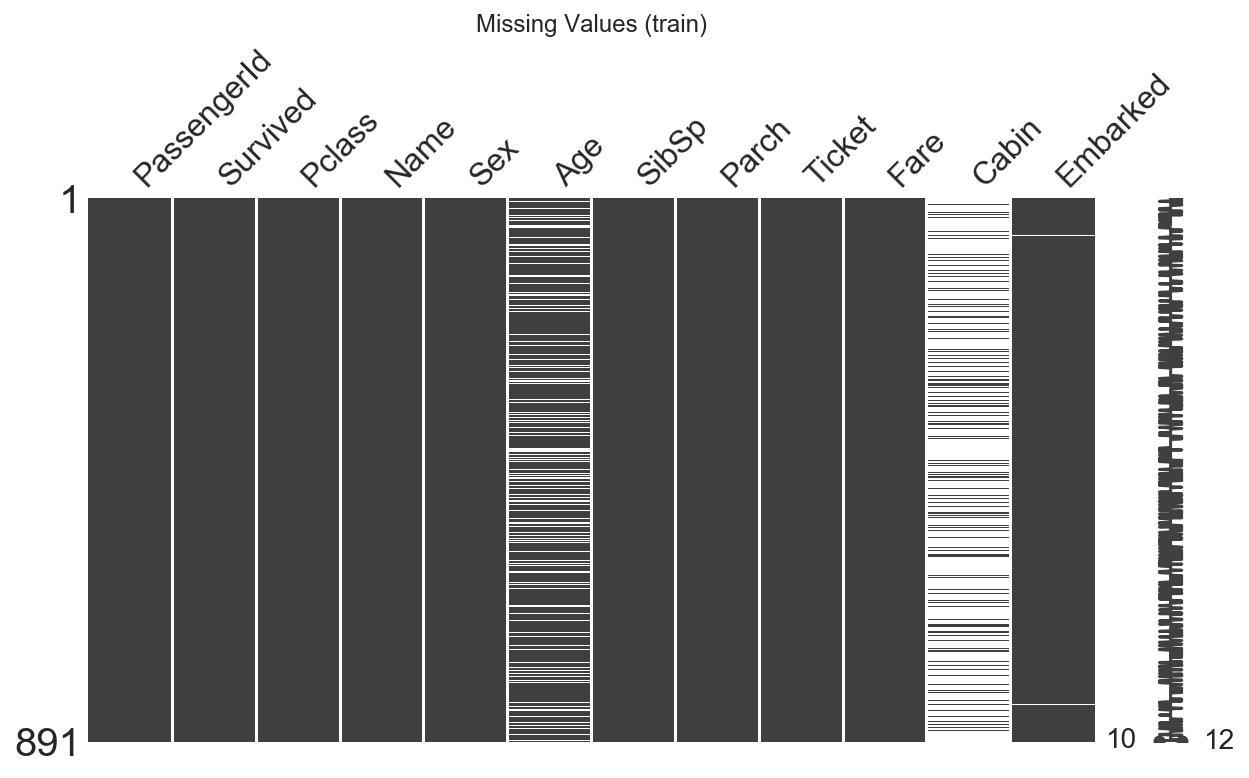

In [145]:
missingno.matrix(train, figsize = (10,5))
plt.title("Missing Values (train)")
plt.show()

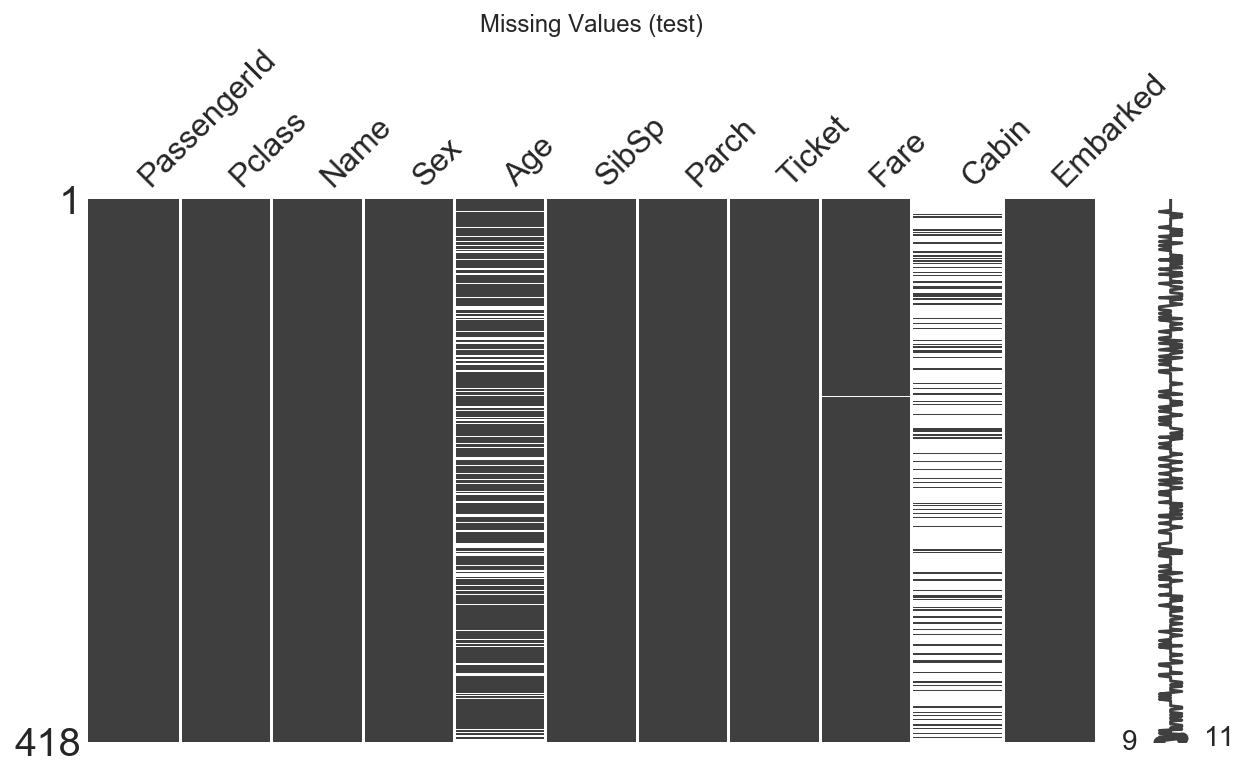

In [146]:
missingno.matrix(test, figsize = (10,5))
plt.title("Missing Values (test)")
plt.show()

In [147]:
train["Embarked"].fillna(train["Embarked"].mode()[0], inplace = True)
train["Age"].fillna(train["Age"].mean(), inplace = True)
train = train.drop(["Cabin", "Ticket"], axis = 1)
print(train.isnull().sum().sort_values(ascending = False).head(3))

print("-------------")

test["Fare"].fillna(test["Fare"].mean(), inplace = True)
test["Age"].fillna(test["Age"].mean(), inplace = True)
test = test.drop(["Cabin", "Ticket"], axis = 1)
print(test.isnull().sum().sort_values(ascending = False).head(3))

Embarked    0
Fare        0
Parch       0
dtype: int64
-------------
Embarked    0
Fare        0
Parch       0
dtype: int64


# 4. Feature engineering

## 4.1 Name Title

In [148]:
train["NameTitle"] = train["Name"].str.split(", ", expand = True)[1].str.split(". ", expand = True)[0]
test["NameTitle"] = test["Name"].str.split(", ", expand = True)[1].str.split(". ", expand = True)[0]

train = train.drop("Name", axis = 1)
test = test.drop("Name", axis = 1)

print(train["NameTitle"].unique())
print("------------------------" * 3)
print(test["NameTitle"].unique())

['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'th' 'Jonkheer']
------------------------------------------------------------------------
['Mr' 'Mrs' 'Miss' 'Master' 'Ms' 'Col' 'Rev' 'Dr' 'Dona']


In [149]:
min_titles = (train["NameTitle"].value_counts() < 10)
train["NameTitle"] = train["NameTitle"].apply(lambda x: "Misc" if min_titles.loc[x] == True else x)
print(train["NameTitle"].unique())

['Mr' 'Mrs' 'Miss' 'Master' 'Misc']


In [150]:
min_titles = (test["NameTitle"].value_counts() < 10)
test["NameTitle"] = test["NameTitle"].apply(lambda x: "Misc" if min_titles.loc[x] == True else x)
print(test["NameTitle"].unique())

['Mr' 'Mrs' 'Miss' 'Master' 'Misc']


## 4.2 Family Size

In [151]:
train["FamilySize"] = train["SibSp"] + train["Parch"]
test["FamilySize"] = test["SibSp"] + test["Parch"]

## 4.3 Age Group

In [152]:
train["AgeGroup"] = ""
train.loc[train["Age"] < 21, "AgeGroup"] = "under 21"
train.loc[train["Age"] >= 21, "AgeGroup"] = "21-65"
train.loc[train["Age"] > 65, "AgeGroup"] = "65+"

test["AgeGroup"] = ""
test.loc[test["Age"] < 21, "AgeGroup"] = "under 21"
test.loc[test["Age"] >= 21, "AgeGroup"] = "21-65"
test.loc[test["Age"] > 65, "AgeGroup"] = "65+"

train = train.drop("Age", axis = 1)
test = test.drop("Age", axis = 1)

## 4.4 Fare Group

In [153]:
train["FareGroup"] = ""
train.loc[train["Fare"] < 170, "FareGroup"] = "0-170"
train.loc[train["Fare"] >= 170, "FareGroup"] = "170-340"
train.loc[train["Fare"] > 340, "FareGroup"] = "340+"

test["FareGroup"] = ""
test.loc[test["Fare"] < 170, "FareGroup"] = "0-170"
test.loc[test["Fare"] >= 170, "FareGroup"] = "170-340"
test.loc[test["Fare"] > 340, "FareGroup"] = "340+"

train = train.drop("Fare", axis = 1)
test = test.drop("Fare", axis = 1)

In [154]:
print(train.shape)
train.head(3)

(891, 11)


PassengerId  Survived  Pclass     Sex  SibSp  Parch Embarked NameTitle  \
0            1         0       3    male      1      0        S        Mr   
1            2         1       1  female      1      0        C       Mrs   
2            3         1       3  female      0      0        S      Miss   

   FamilySize AgeGroup FareGroup  
0           1    21-65     0-170  
1           1    21-65     0-170  
2           0    21-65     0-170

In [155]:
print(test.shape)
test.head(3)

(418, 10)


PassengerId  Pclass     Sex  SibSp  Parch Embarked NameTitle  FamilySize  \
0          892       3    male      0      0        Q        Mr           0   
1          893       3  female      1      0        S       Mrs           1   
2          894       2    male      0      0        Q        Mr           0   

  AgeGroup FareGroup  
0    21-65     0-170  
1    21-65     0-170  
2    21-65     0-170

# 5. Data visualization

## 5.1 Survived

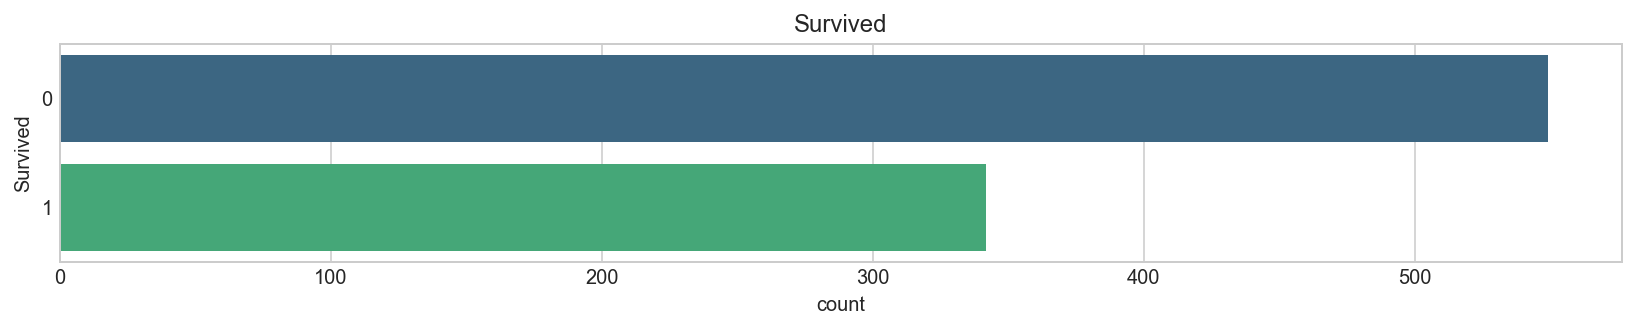

In [156]:
plt.figure(figsize = (14,2))
sns.countplot(data = train, y = "Survived", palette = "viridis")
plt.title("Survived")
plt.show()

## 5.2 Class

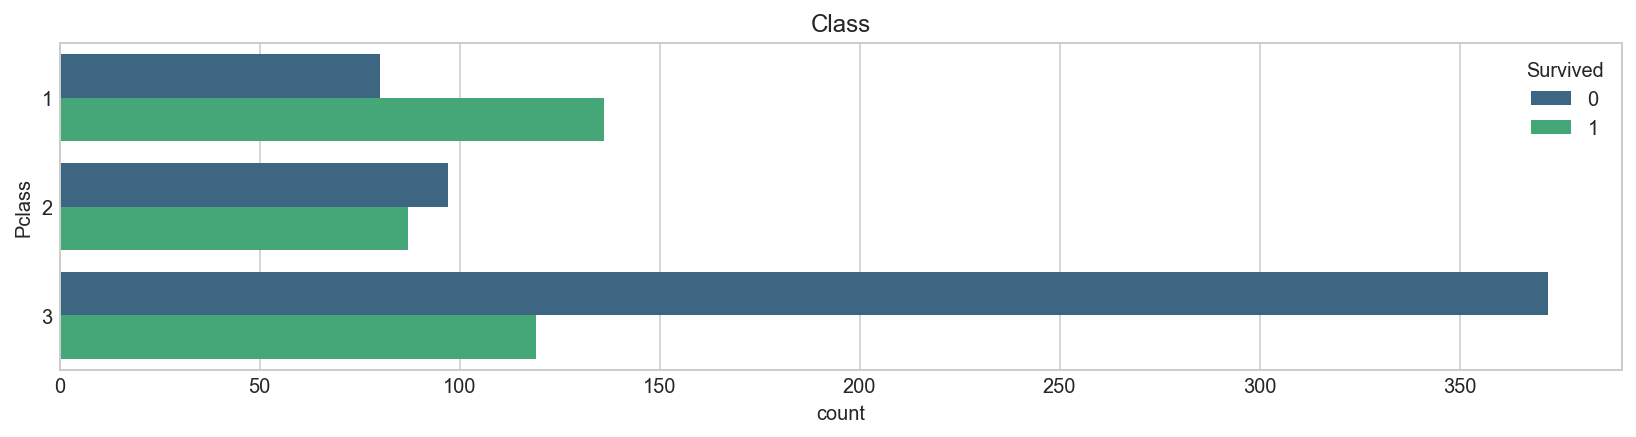

In [157]:
plt.figure(figsize = (14,3))
sns.countplot(data = train, y = "Pclass", hue = "Survived", palette = "viridis")
plt.title("Class")
plt.show()

## 5.3 Gender

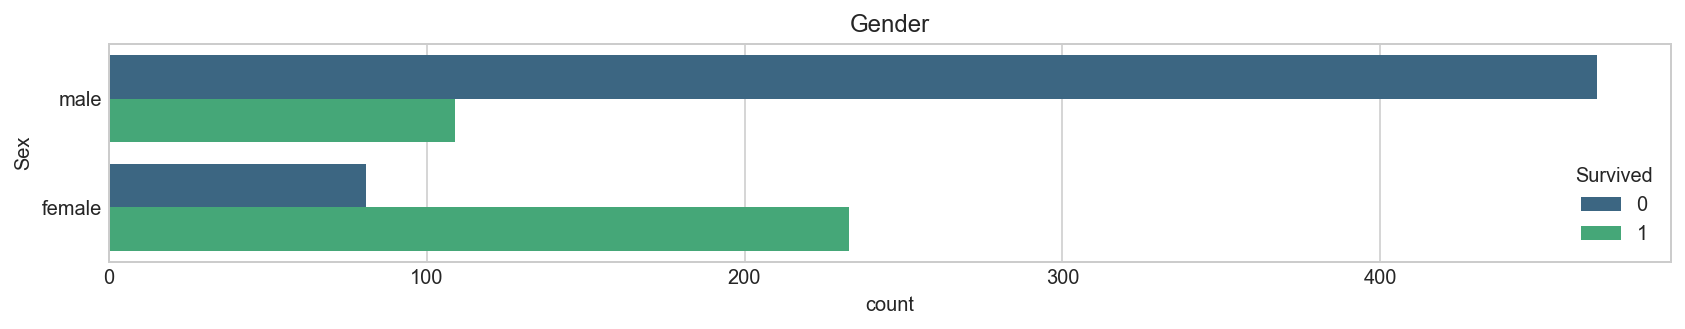

In [158]:
plt.figure(figsize = (14,2))
sns.countplot(data = train, y = "Sex", hue = "Survived", palette = "viridis")
plt.title("Gender")
plt.show()

## 5.4 Family Size

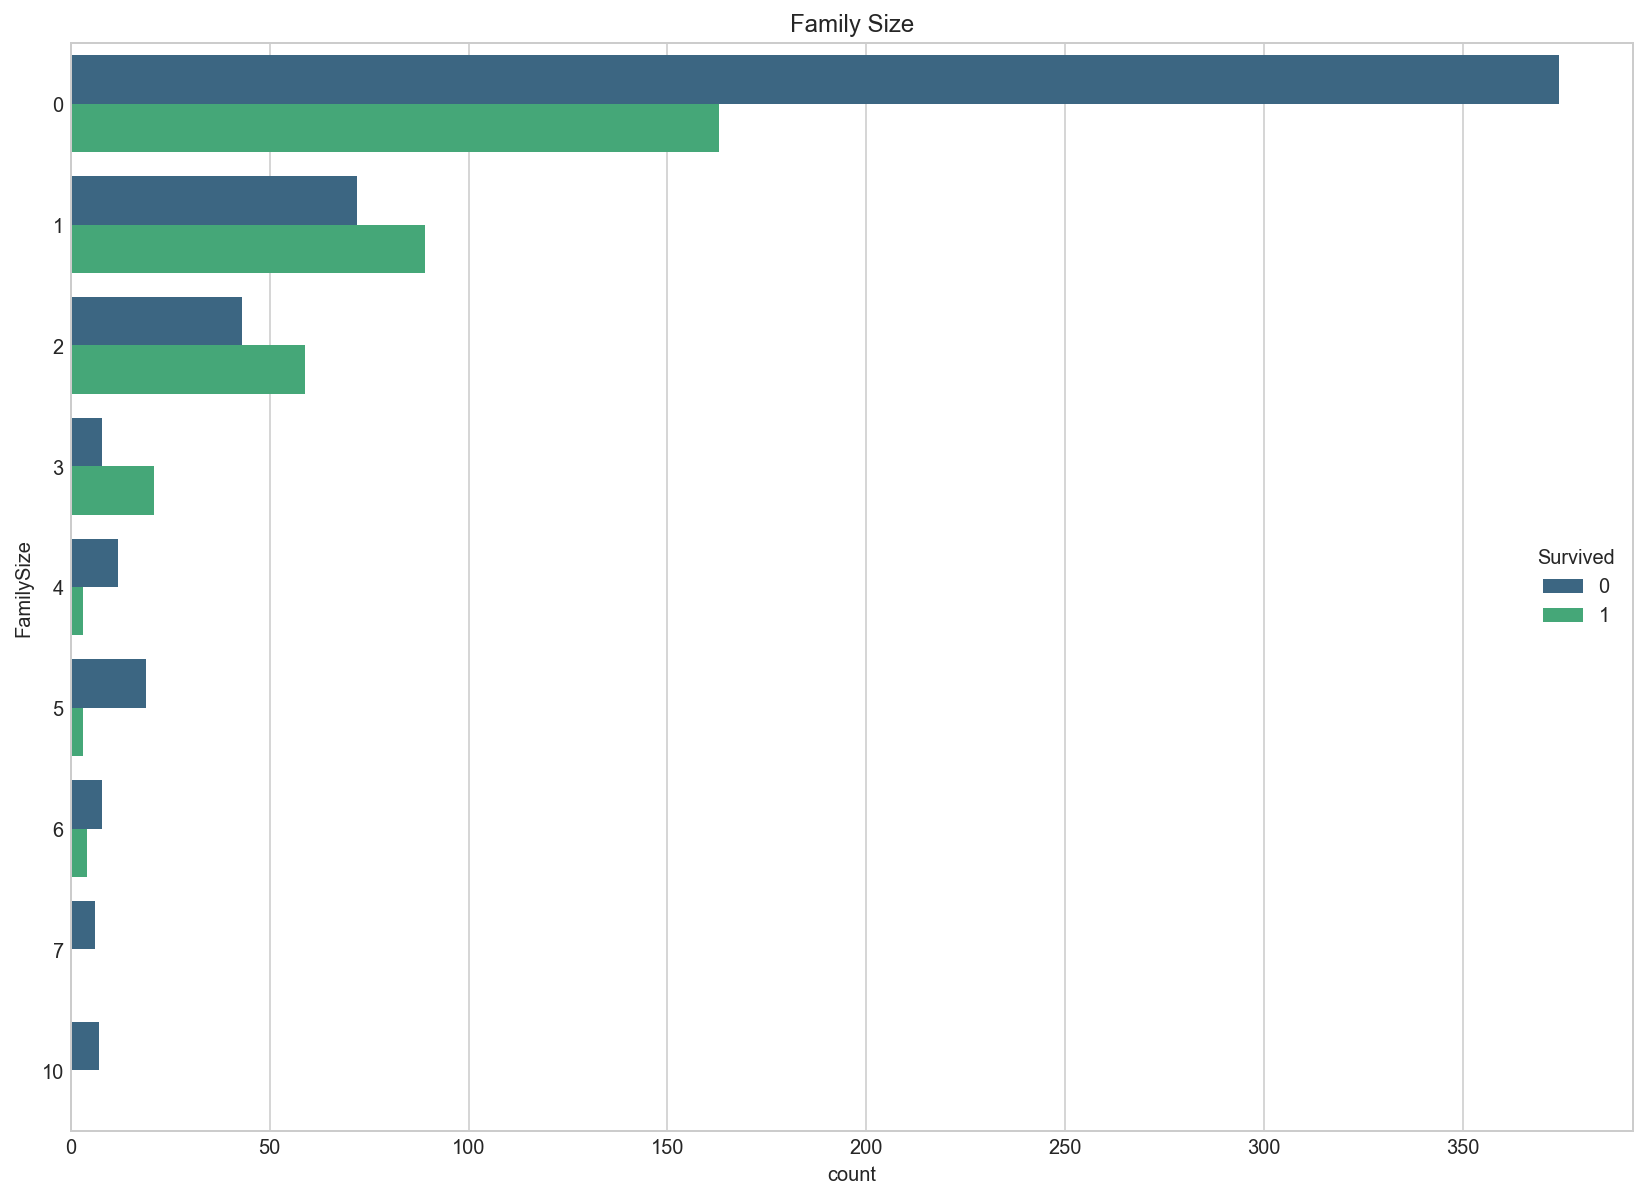

In [159]:
plt.figure(figsize = (14,10))
sns.countplot(data = train, y = "FamilySize", hue = "Survived", palette = "viridis")
plt.title("Family Size")
plt.show()

## 5.5 Embarked

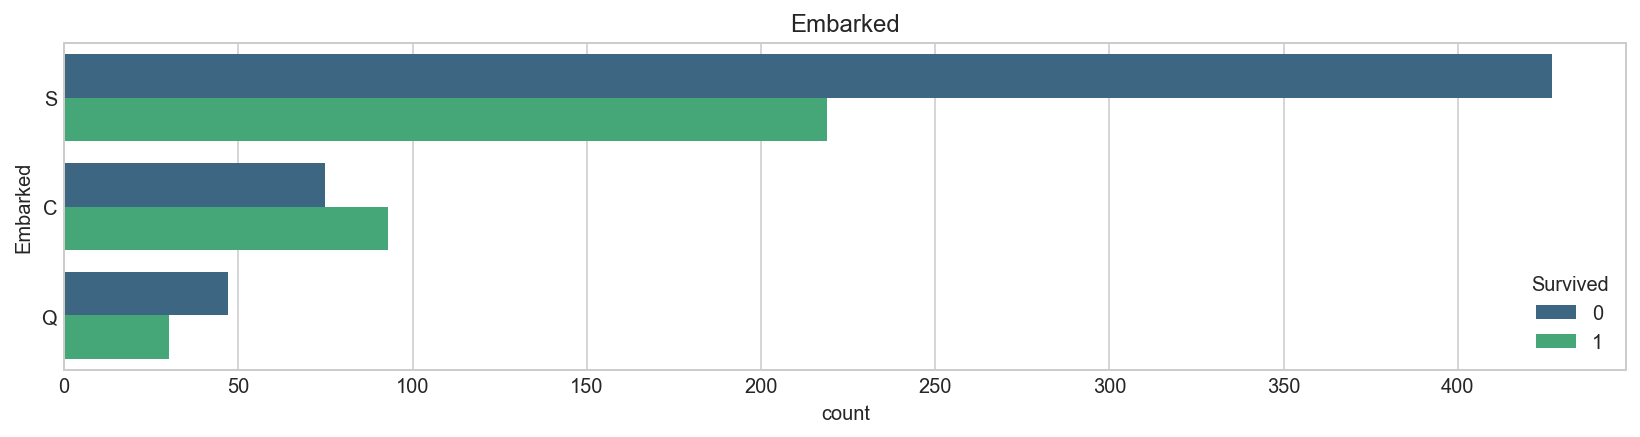

In [160]:
plt.figure(figsize = (14,3))
sns.countplot(data = train, y = "Embarked", hue = "Survived", palette = "viridis")
plt.title("Embarked")
plt.show()

## 5.6 Name Title

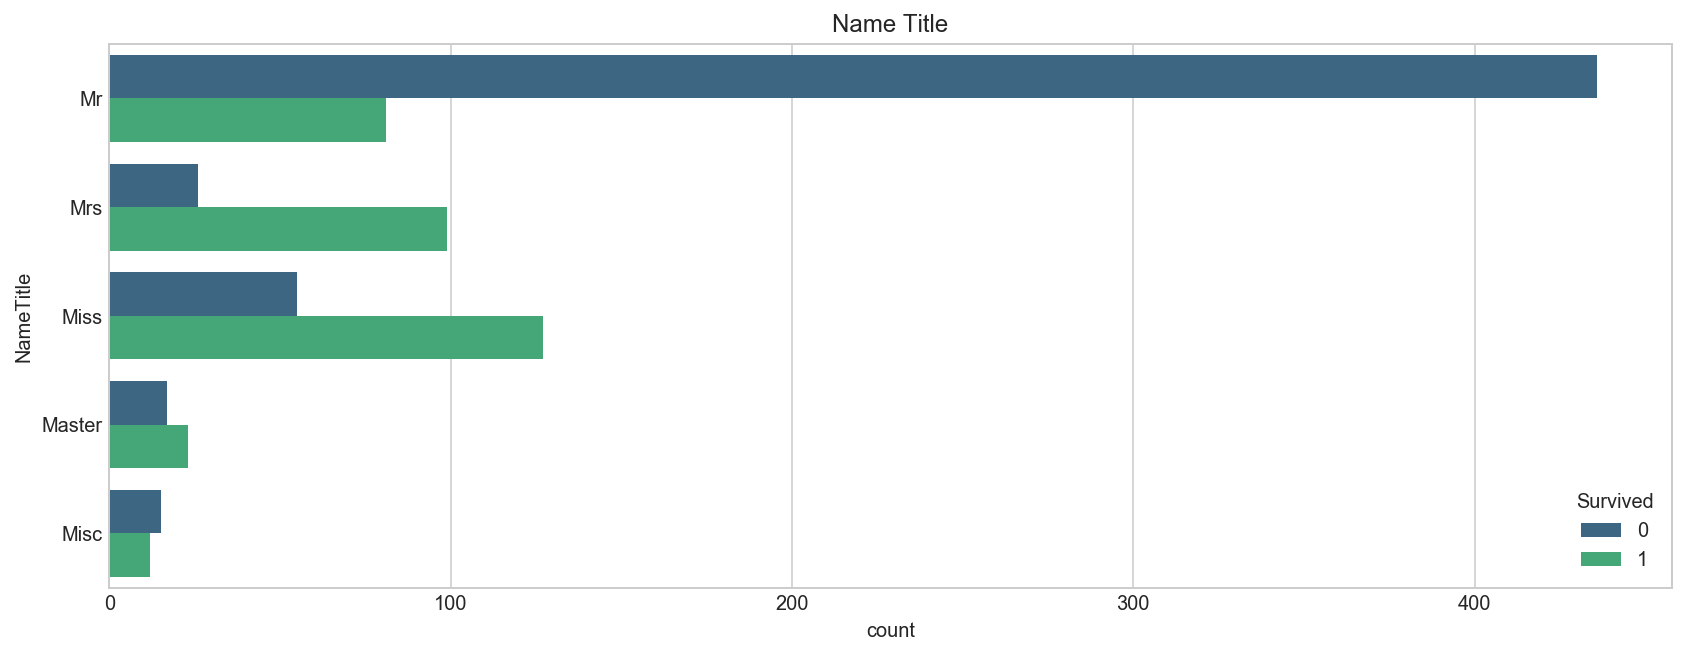

In [161]:
plt.figure(figsize = (14,5))
sns.countplot(data = train, y = "NameTitle", hue = "Survived", palette = "viridis")
plt.title("Name Title")
plt.show()

## 5.7 Age Group

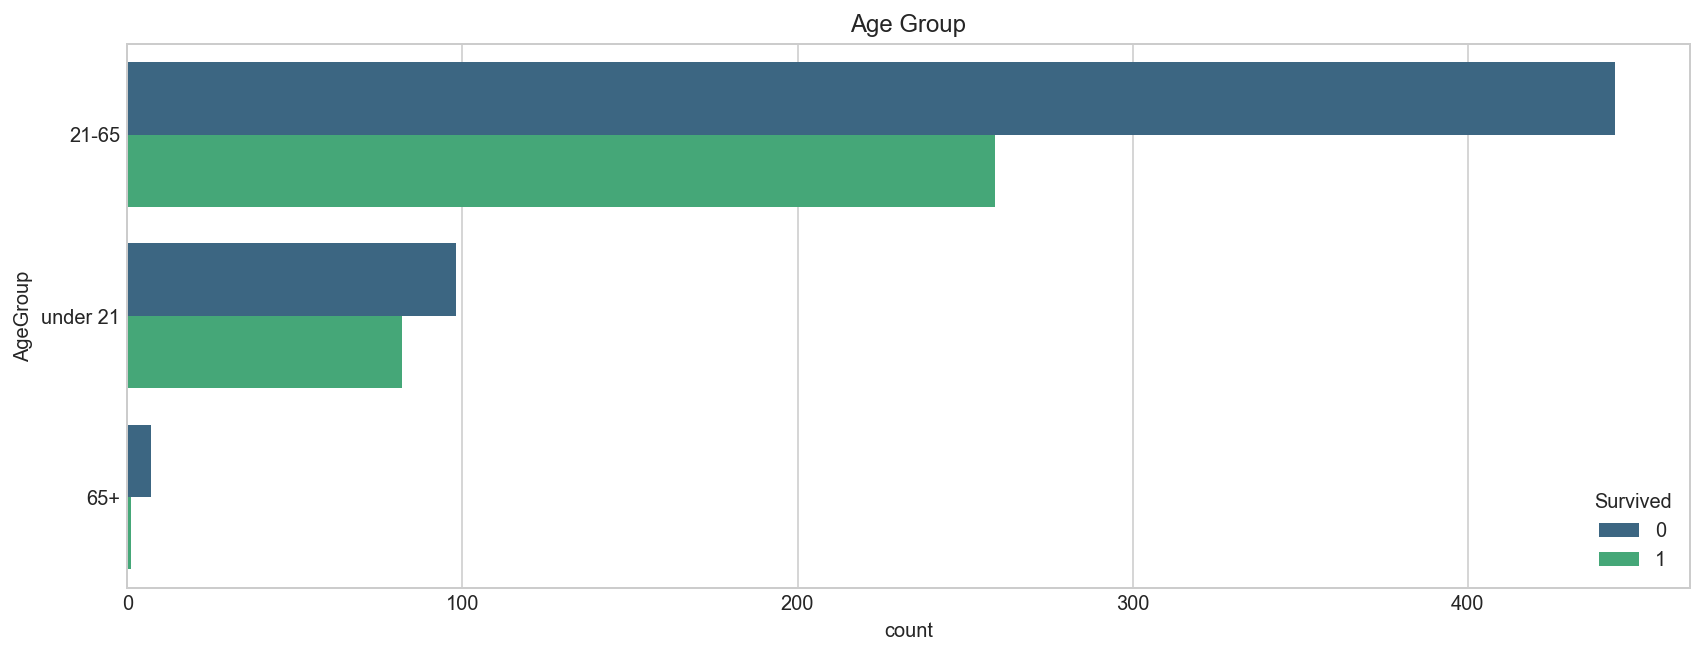

In [162]:
plt.figure(figsize = (14,5))
sns.countplot(data = train, y = "AgeGroup", hue = "Survived", palette = "viridis")
plt.title("Age Group")
plt.show()

## 5.8 Fare Group

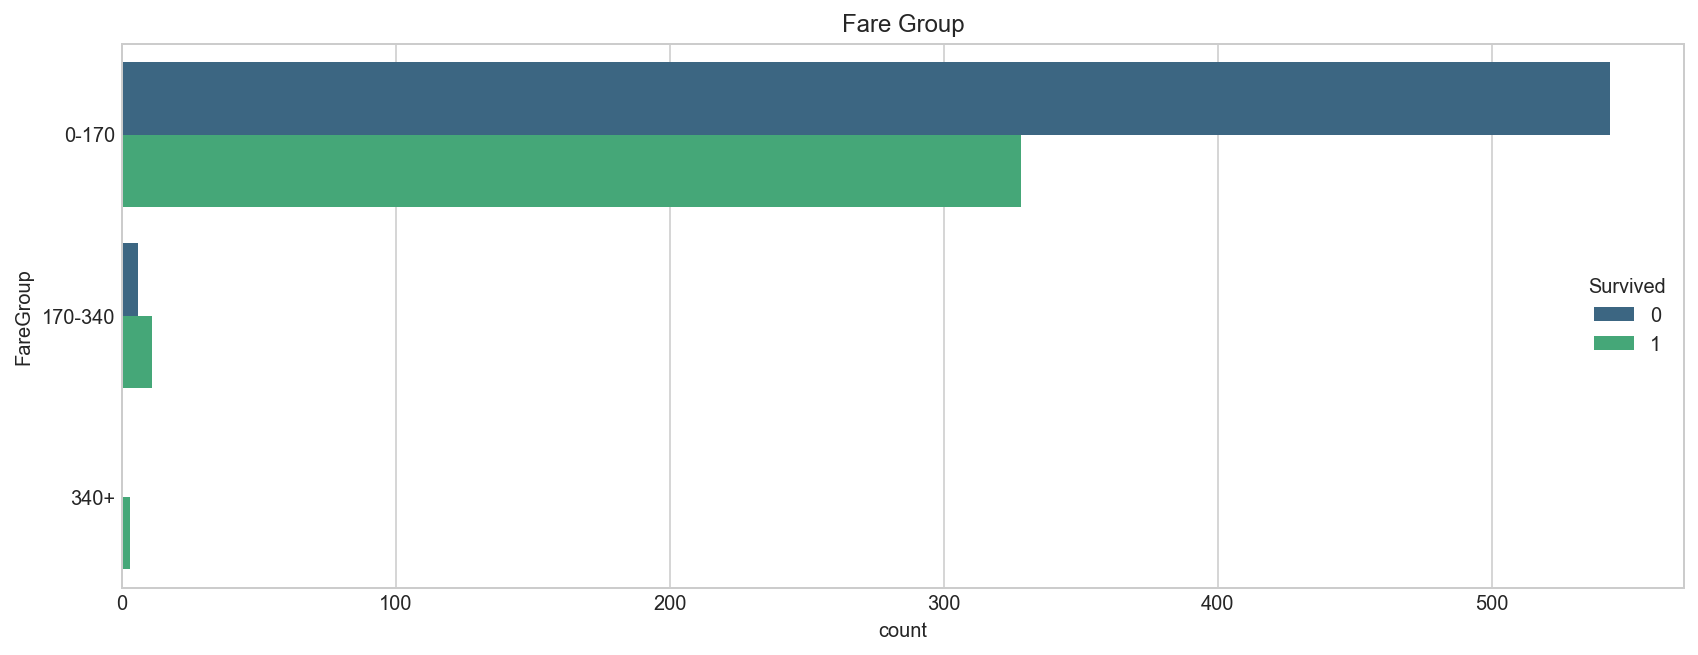

In [163]:
plt.figure(figsize = (14,5))
sns.countplot(data = train, y = "FareGroup", hue = "Survived", palette = "viridis")
plt.title("Fare Group")
plt.show()

## 5.9 Correlation

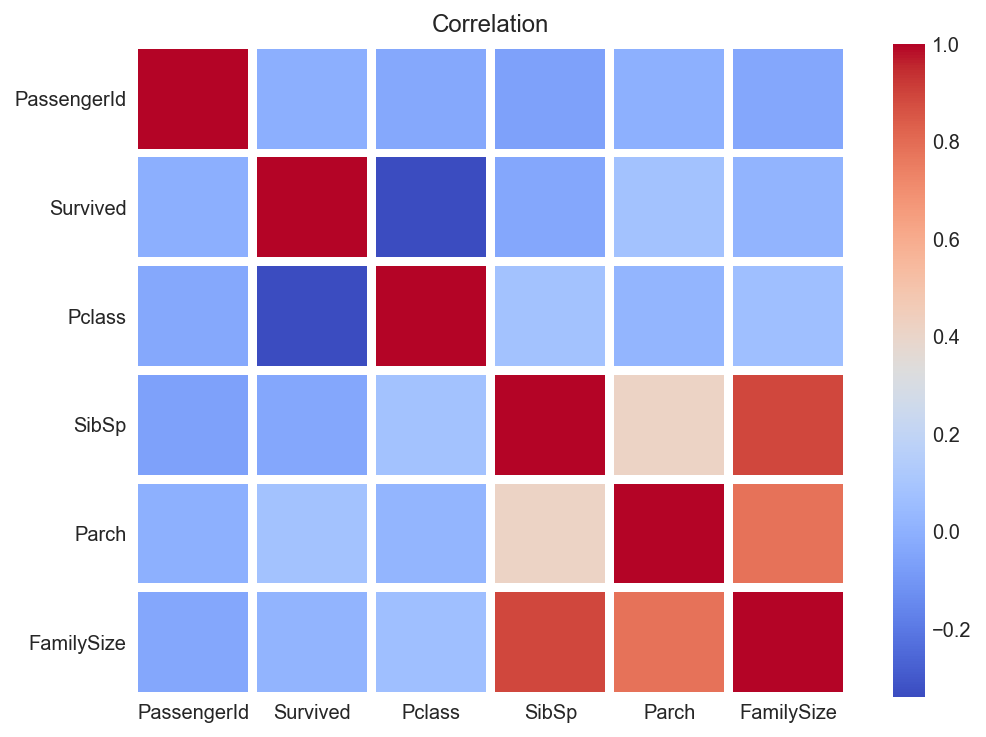

In [164]:
corr = train.corr()
plt.figure(figsize = (8,6))
sns.heatmap(corr, cmap = "coolwarm", linewidth = 4, linecolor = "white")
plt.title("Correlation")
plt.show()

In [165]:
train = pd.get_dummies(train, columns = ["Sex", "Embarked", "NameTitle", "AgeGroup", "FareGroup"])
test = pd.get_dummies(test, columns = ["Sex", "Embarked", "NameTitle", "AgeGroup", "FareGroup"])

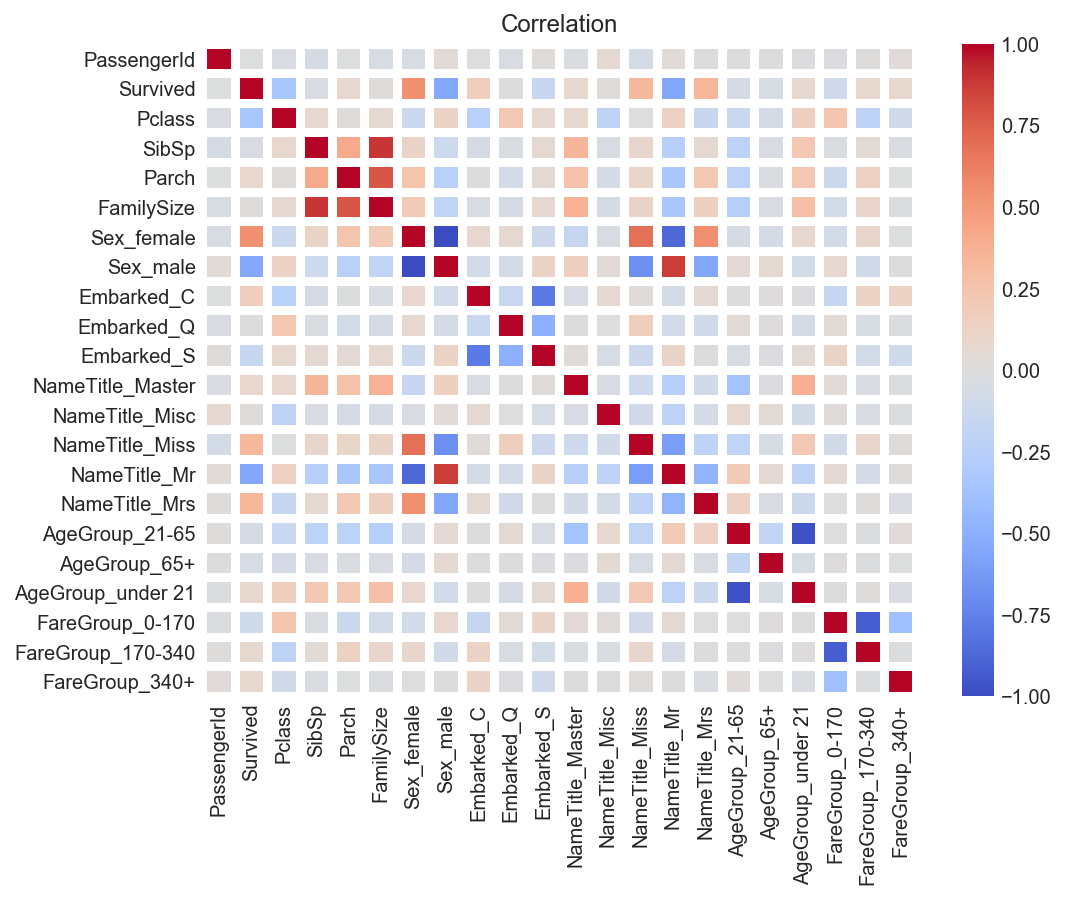

In [166]:
corr = train.corr()
plt.figure(figsize = (8,6))
sns.heatmap(corr, cmap = "coolwarm", linewidth = 4, linecolor = "white")
plt.title("Correlation")
plt.show()

In [167]:
upper = corr.where(np.triu(np.ones(corr.shape), k = 1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
print(to_drop)

[]


# 6. PCA

In [168]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = train.drop(["PassengerId", "Survived"], axis = 1)
Y = train["Survived"]

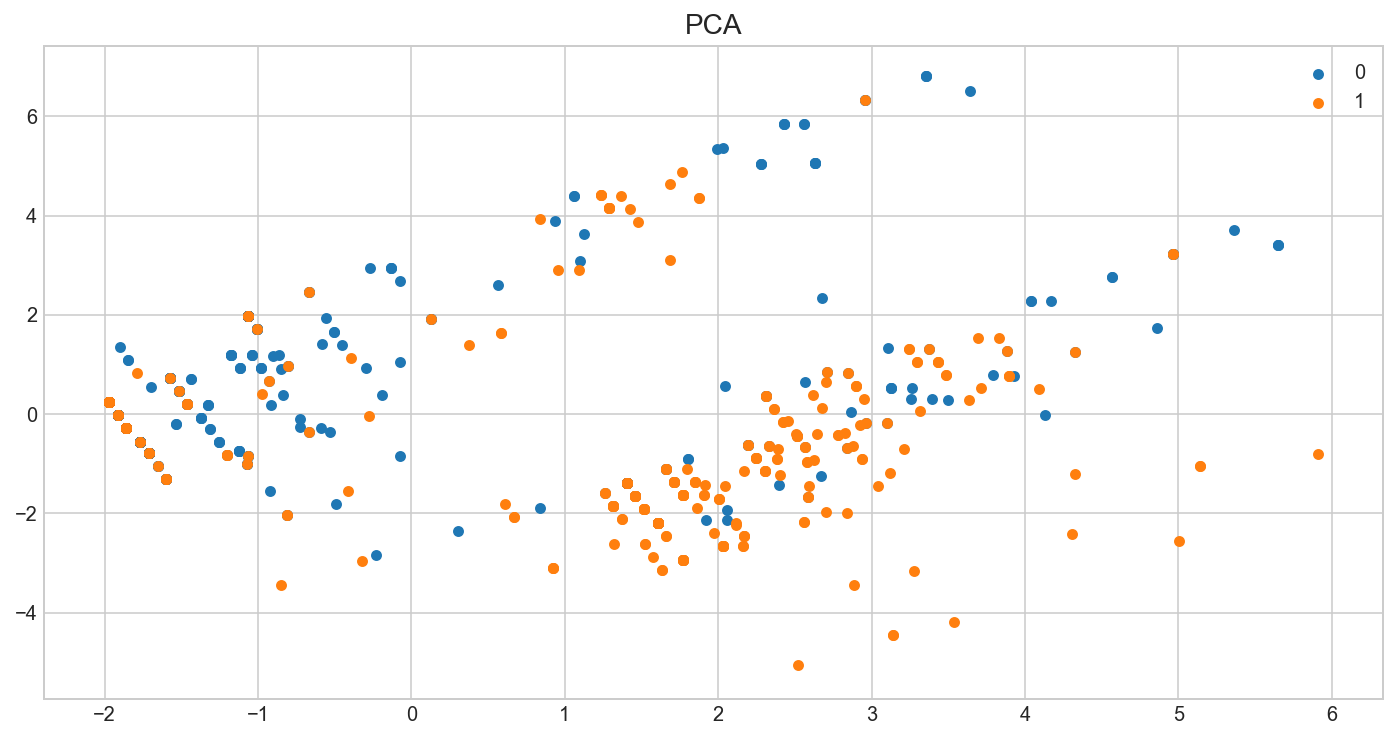

In [169]:
scaler = StandardScaler()
X_pca = scaler.fit_transform(X)

pca = PCA(n_components = 2)
X_pca_transformed = pca.fit_transform(X_pca)

plt.figure(figsize = (12,6))

for i in Y.unique():
    X_pca_filtered = X_pca_transformed[Y == i, :]
    plt.scatter(X_pca_filtered[:, 0], X_pca_filtered[:, 1], s = 20, label = i)
    
plt.legend()
plt.title("PCA", fontsize = 14)
plt.show()

# 7. Machine Learning

In [170]:
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [171]:
# 极而言之就是0,1,2在y中所站的比例和0,1,2在y_train中的比例一致。

## 7.1 XGBoost

[![xgboost para](https://img2018.cnblogs.com/blog/1507784/201908/1507784-20190830170241418-978540991.png)](https://www.cnblogs.com/TimVerion/p/11436001.html)

[grid_search](https://www.jianshu.com/p/55b9f2ea283b)

In [172]:
pipe_xgb = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA()),
    ("xgb", XGBClassifier())])

params = {
    "pca__n_components" : [2, 6, 10, 18],
    "xgb__n_estimators" : [300, 500, 700],
    "xgb__learning_rate" : [0.005, 0.1],
    "xgb__max_depth" : [5, 7],
    "xgb__max_features" : [3, 5], 
    "xgb__gamma" : [0.5, 0.6, 0.7]}

cv = StratifiedShuffleSplit(n_splits = 5, 
                            test_size = 0.3, 
                            random_state = 15)

grid_xgb = GridSearchCV(pipe_xgb, params, cv = cv, verbose = 1, n_jobs = -1)
grid_xgb = grid_xgb.fit(X, Y)

results_xgb = grid_xgb.cv_results_["mean_test_score"]
print(grid_xgb.best_params_)

grid_xgb = grid_xgb.best_estimator_
grid_xgb.fit(X, Y)

print("")
print("#" * 6 + " ACCURACY " + "#" * 6)
print("Score: " + str(round(grid_xgb.score(X, Y), 6)))
print("#" * 22)

Y_predicted_xgb = grid_xgb.predict_proba(X)[:, 1]

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  4.0min finished


[12:52:36] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { max_features } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


{'pca__n_components': 10, 'xgb__gamma': 0.7, 'xgb__learning_rate': 0.005, 'xgb__max_depth': 5, 'xgb__max_features': 3, 'xgb__n_estimators': 500}
[12:52:37] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { max_features } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



###### ACCURACY ######
Score: 0.851852
######################


In [173]:
GradientBoostingClassifier()

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

## 7.2 Gradient Boosting

In [174]:
pipe_boost = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA()),
    ("boost", GradientBoostingClassifier())])

params = {
    "pca__n_components" : [2, 6, 10, 18],
    "boost__n_estimators" : [300, 500, 700],
    "boost__learning_rate" : [0.005, 0.1],
    "boost__max_depth" : [3, 5],
    "boost__max_features" : [1,2]}

cv = StratifiedShuffleSplit(n_splits = 5, 
                            test_size = 0.3, 
                            random_state = 15)

grid_boost = GridSearchCV(pipe_boost, params, cv = cv, verbose = 1, n_jobs = -1)
grid_boost = grid_boost.fit(X, Y)

results_boost = grid_boost.cv_results_["mean_test_score"]
print(grid_boost.best_params_)

grid_boost = grid_boost.best_estimator_
grid_boost.fit(X, Y)

print("")
print("#" * 6 + " ACCURACY " + "#" * 6)
print("Score: " + str(round(grid_boost.score(X, Y), 6)))
print("#" * 22)

Y_predicted_boost = grid_boost.predict_proba(X)[:, 1]

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  1.5min finished


{'boost__learning_rate': 0.005, 'boost__max_depth': 3, 'boost__max_features': 1, 'boost__n_estimators': 500, 'pca__n_components': 18}

###### ACCURACY ######
Score: 0.847363
######################


## 7.3 Logistic Regression

In [175]:
pipe_log = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA()),
    ("log", LogisticRegression())])

params = {
    "pca__n_components" : [2, 6, 10, 18],
    "log__C" : [0.001, 0.01, 0.1, 1, 1.1, 10],
    "log__max_iter" : [10000],
    "log__solver" : ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]}

cv = StratifiedShuffleSplit(n_splits = 5, 
                            test_size = 0.3, 
                            random_state = 15)

grid_log = GridSearchCV(pipe_log, params, cv = cv, verbose = 1, n_jobs = -1)
grid_log = grid_log.fit(X, Y)

results_log = grid_log.cv_results_["mean_test_score"]
print(grid_log.best_params_)

grid_log = grid_log.best_estimator_
grid_log.fit(X, Y)

print("")
print("#" * 6 + " ACCURACY " + "#" * 6)
print("Score: " + str(round(grid_log.score(X, Y), 6)))
print("#" * 22)

Y_predicted_log = grid_log.predict_proba(X)[:, 1]

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    5.0s finished


{'log__C': 0.1, 'log__max_iter': 10000, 'log__solver': 'newton-cg', 'pca__n_components': 18}

###### ACCURACY ######
Score: 0.836139
######################


## 7.4 Random Forest

In [176]:
pipe_rf = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA()),
    ("rf", RandomForestClassifier(criterion = "gini", 
                                  max_features = "auto"))])

params = {
    "pca__n_components" : [2, 6, 10, 18],
    "rf__n_estimators" : [200, 250, 300, 400],
    "rf__max_depth" : [1, 3, 5, 7, 9]}

cv = StratifiedShuffleSplit(n_splits = 5, 
                            test_size = 0.3, 
                            random_state = 15)

grid_rf = GridSearchCV(pipe_rf, params, cv = cv, verbose = 1, n_jobs = -1)
grid_rf = grid_rf.fit(X, Y)

results_rf = grid_rf.cv_results_["mean_test_score"]
print(grid_rf.best_params_)

grid_rf = grid_rf.best_estimator_
grid_rf.fit(X, Y)

print("")
print("#" * 6 + " ACCURACY " + "#" * 6)
print("Score: " + str(round(grid_rf.score(X, Y), 6)))
print("#" * 22)

Y_predicted_rf = grid_rf.predict_proba(X)[:, 1]

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   59.9s finished


{'pca__n_components': 18, 'rf__max_depth': 3, 'rf__n_estimators': 250}

###### ACCURACY ######
Score: 0.838384
######################


## 7.5 SVM

In [177]:
pipe_svm = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA()),
    ("svm", SVC(probability = True, kernel = "rbf"))])

params = {
    "pca__n_components" : [2, 6, 10, 18],
    "svm__C" : [0.01, 0.1, 1, 1.1, 2],
    "svm__gamma" : [0.01, 0.1, 1]}

cv = StratifiedShuffleSplit(n_splits = 5, 
                            test_size = 0.3, 
                            random_state = 15)

grid_svm = GridSearchCV(pipe_svm, params, cv = cv, verbose = 1, n_jobs = -1)
grid_svm = grid_svm.fit(X, Y)

results_svm = grid_svm.cv_results_["mean_test_score"]
print(grid_svm.best_params_)

grid_svm = grid_svm.best_estimator_
grid_svm.fit(X, Y)

print("")
print("#" * 6 + " ACCURACY " + "#" * 6)
print("Score: " + str(round(grid_svm.score(X, Y), 6)))
print("#" * 22)

Y_predicted_svm = grid_svm.predict_proba(X)[:, 1]

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    6.2s finished


{'pca__n_components': 10, 'svm__C': 1.1, 'svm__gamma': 0.1}

###### ACCURACY ######
Score: 0.838384
######################


## 7.6 Bagging Classifier

In [178]:
pipe_bag = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA()),
    ("bag", BaggingClassifier())])

params = {
    "pca__n_components" : [2, 6, 10, 18],
    "bag__n_estimators" : [30, 50, 70, 100],
    "bag__max_features" : [1,2],
    "bag__max_samples" : [3, 5, 7, 9]}

cv = StratifiedShuffleSplit(n_splits = 5, 
                            test_size = 0.3, 
                            random_state = 15)

grid_bag = GridSearchCV(pipe_bag, params, cv = cv, verbose = 1, n_jobs = -1)
grid_bag = grid_bag.fit(X, Y)

results_bag = grid_bag.cv_results_["mean_test_score"]
print(grid_bag.best_params_)

grid_bag = grid_bag.best_estimator_
grid_bag.fit(X, Y)

print("")
print("#" * 6 + " ACCURACY " + "#" * 6)
print("Score: " + str(round(grid_bag.score(X, Y), 6)))
print("#" * 22)

Y_predicted_bag = grid_bag.predict_proba(X)[:, 1]

Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:   17.5s finished


{'bag__max_features': 2, 'bag__max_samples': 9, 'bag__n_estimators': 70, 'pca__n_components': 2}

###### ACCURACY ######
Score: 0.787879
######################


## 7.7 Extra Trees Classifier

In [179]:
pipe_xt = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA()),
    ("xt", ExtraTreesClassifier(criterion = "gini", 
                                max_features = "auto"))])

params = {
    "pca__n_components" : [2, 6, 10, 18],
    "xt__n_estimators" : [300, 500, 700],
    "xt__max_depth" : [5, 7, 9]}

cv = StratifiedShuffleSplit(n_splits = 5, 
                            test_size = 0.3, 
                            random_state = 15)

grid_xt = GridSearchCV(pipe_xt, params, cv = cv, verbose = 1, n_jobs = -1)
grid_xt = grid_xt.fit(X, Y)

results_xt = grid_xt.cv_results_["mean_test_score"]
print(grid_xt.best_params_)

grid_xt = grid_xt.best_estimator_
grid_xt.fit(X, Y)

print("")
print("#" * 6 + " ACCURACY " + "#" * 6)
print("Score: " + str(round(grid_xt.score(X, Y), 6)))
print("#" * 22)

Y_predicted_xt = grid_xt.predict_proba(X)[:, 1]

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   38.6s finished


{'pca__n_components': 6, 'xt__max_depth': 5, 'xt__n_estimators': 300}

###### ACCURACY ######
Score: 0.837262
######################


## 7.8 K-Nearest-Neighbor

In [180]:
pipe_knn = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA()),
    ("knn", KNeighborsClassifier(algorithm = "auto"))])

params = {
    "pca__n_components" : [2, 6, 10, 18],
    "knn__n_neighbors" : [3, 5, 7, 9, 11, 13, 15],
    "knn__leaf_size" : [10, 20, 30, 40]}

cv = StratifiedShuffleSplit(n_splits = 5, 
                            test_size = 0.3, 
                            random_state = 15)

grid_knn = GridSearchCV(pipe_knn, params, cv = cv, verbose = 1, n_jobs = -1)
grid_knn = grid_knn.fit(X, Y)

results_knn = grid_knn.cv_results_["mean_test_score"]
print(grid_knn.best_params_)

grid_knn = grid_knn.best_estimator_
grid_knn.fit(X, Y)

print("")
print("#" * 6 + " ACCURACY " + "#" * 6)
print("Score: " + str(round(grid_knn.score(X, Y), 6)))
print("#" * 22)

Y_predicted_knn = grid_knn.predict_proba(X)[:, 1]

Fitting 5 folds for each of 112 candidates, totalling 560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 560 out of 560 | elapsed:    4.3s finished


{'knn__leaf_size': 10, 'knn__n_neighbors': 13, 'pca__n_components': 6}

###### ACCURACY ######
Score: 0.822671
######################


## 7.9 Model visualization

In [181]:
all_results = [results_xgb, results_boost, results_log, results_rf, 
               results_svm, results_bag, results_xt, results_knn]

result_names = ["XGBoost", 
                "Gradient Boosting", 
                "Logistic Regression", 
                "Random Forest", 
                "SVM", 
                "Bagging Classifier", 
                "Extra Trees Classifier", 
                "KNN"]

#fig = plt.figure(figsize = (14,7))
#fig.suptitle("Algorithm Comparison (Stratified KFold)")
#ax = fig.add_subplot(111)
#plt.boxplot(all_results)
#ax.set_xticklabels(result_names)
#plt.show()

# 8. Neural Network

In [182]:
%%capture
!pip install keras-tuner

In [183]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from kerastuner.tuners import RandomSearch

In [184]:
X_train, X_test, Y_train, Y_test = train_test_split(X, 
                                                    Y, 
                                                    random_state = 0, 
                                                    test_size = 0.25)

In [186]:
%%capture

def tune_model(hp):

    nn = Sequential()

    nn.add(Dense(hp.Choice("units_1", [512, 1024, 2048]), activation = "relu", input_shape = (20,)))
    nn.add(Dropout(hp.Choice("dropout_1", [0.0, 0.15, 0.2, 0.25])))
    nn.add(Dense(hp.Choice("units_2", [128, 256, 512]), activation = "relu"))
    nn.add(Dropout(hp.Choice("dropout_2", [0.0, 0.15, 0.2, 0.25])))
    nn.add(Dense(hp.Choice("units_3", [32, 64, 128]), activation = "relu"))
    nn.add(Dropout(hp.Choice("dropout_3", [0.0, 0.15, 0.2, 0.25])))
    nn.add(Dense(hp.Choice("units_4", [8, 16, 32]), activation = "relu"))
    nn.add(Dropout(hp.Choice("dropout_4", [0.0, 0.15, 0.2, 0.25])))
    nn.add(Dense(1, activation = "relu"))
    
    lr = hp.Choice("learning_rate", [0.0001, 0.001, 0.01, 0.1])
    mm = hp.Choice("momentum", [0.0, 0.2, 0.4, 0.6, 0.8])
    
    nn.compile(optimizer = keras.optimizers.RMSprop(learning_rate = lr, momentum = mm), 
               loss = "binary_crossentropy", 
               metrics = ["accuracy"])
    
    return nn

tuner = RandomSearch(tune_model, 
                     objective='val_accuracy',
                     max_trials=3
                    )

tuner.search(x = X_train, 
             y = Y_train, 
             verbose = 3, 
             epochs = 400, 
             batch_size = 25, 
             validation_data = (X_test, Y_test))

INFO:tensorflow:Reloading Oracle from existing project .\untitled_project\oracle.json
INFO:tensorflow:Oracle triggered exit


In [187]:
print("Best Params: " + str(tuner.oracle.get_best_trials(num_trials = 1)[0].hyperparameters.values))

nn = tuner.get_best_models()[0]

print("")
print("Test score: " + str(nn.evaluate(X_test, Y_test)))
print("")
print("Train score: " + str(nn.evaluate(X_train, Y_train)))

Best Params: {'units_1': 1024, 'dropout_1': 0.25, 'units_2': 512, 'dropout_2': 0.15, 'units_3': 64, 'dropout_3': 0.25, 'units_4': 32, 'dropout_4': 0.25, 'learning_rate': 0.0001, 'momentum': 0.8}

223/223 [==============================] - ETA: 0s - loss: 0.2564 - accuracy: 0.90 - 0s 737us/sample - loss: 0.5517 - accuracy: 0.8341
Test score: [0.5516631426832601, 0.8340807]

668/668 [==============================] - ETA: 0s - loss: 0.3596 - accuracy: 0.84 - 0s 63us/sample - loss: 0.5543 - accuracy: 0.8413
Train score: [0.5543455037171255, 0.84131736]


In [188]:
Y_predicted_nn = nn.predict(test.drop(["PassengerId"], axis = 1))
Y_predicted_nn = (Y_predicted_nn.ravel() > 0.5).astype(int)

# 9. ROC-Curve and AUC-Score

In [189]:
from sklearn.metrics import roc_curve, roc_auc_score

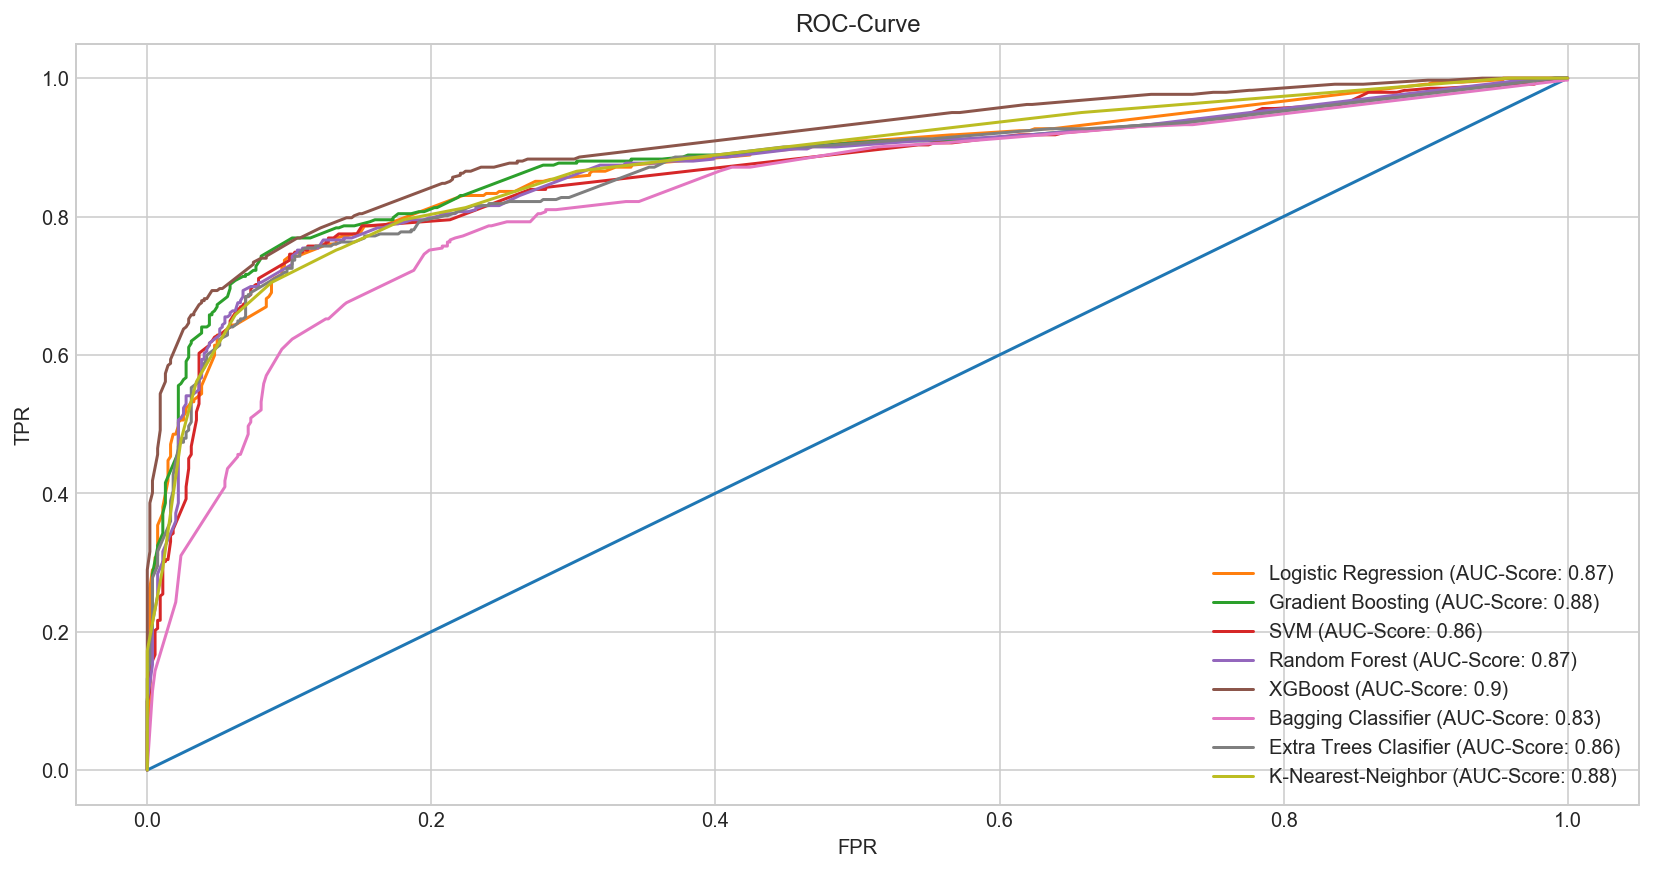

In [190]:
log_fpr, log_tpr, log_treshholds = roc_curve(Y, Y_predicted_log)
boost_fpr, boost_tpr, boost_treshholds = roc_curve(Y, Y_predicted_boost) 
svm_fpr, svm_tpr, svm_treshholds = roc_curve(Y, Y_predicted_svm)
rf_fpr, rf_tpr, rf_treshholds = roc_curve(Y, Y_predicted_rf)
xgb_fpr, xgb_tpr, xgb_treshholds = roc_curve(Y, Y_predicted_xgb)
bag_fpr, bag_tpr, bag_treshholds = roc_curve(Y, Y_predicted_bag)
xt_fpr, xt_tpr, xt_treshholds = roc_curve(Y, Y_predicted_xt)
knn_fpr, knn_tpr, knn_treshholds = roc_curve(Y, Y_predicted_knn)

auc_score_log = roc_auc_score(Y, Y_predicted_log)
auc_score_boost = roc_auc_score(Y, Y_predicted_boost)
auc_score_svm = roc_auc_score(Y, Y_predicted_svm)
auc_score_rf = roc_auc_score(Y, Y_predicted_rf)
auc_score_xgb = roc_auc_score(Y, Y_predicted_xgb)
auc_score_bag = roc_auc_score(Y, Y_predicted_bag)
auc_score_xt = roc_auc_score(Y, Y_predicted_xt)
auc_score_knn = roc_auc_score(Y, Y_predicted_knn)

plt.figure(figsize = (14,7))
plt.plot([0,1], [0,1])
plt.plot(log_fpr, log_tpr, label = "Logistic Regression (AUC-Score: " + str(round(auc_score_log, 2)) + ")")
plt.plot(boost_fpr, boost_tpr, label = "Gradient Boosting (AUC-Score: " + str(round(auc_score_boost, 2)) + ")")
plt.plot(svm_fpr, svm_tpr, label = "SVM (AUC-Score: " + str(round(auc_score_svm, 2)) + ")")
plt.plot(rf_fpr, rf_tpr, label = "Random Forest (AUC-Score: " + str(round(auc_score_rf, 2)) + ")")
plt.plot(xgb_fpr, xgb_tpr, label = "XGBoost (AUC-Score: " + str(round(auc_score_xgb, 2)) + ")")
plt.plot(bag_fpr, bag_tpr, label = "Bagging Classifier (AUC-Score: " + str(round(auc_score_bag, 2)) + ")")
plt.plot(xt_fpr, xt_tpr, label = "Extra Trees Clasifier (AUC-Score: " + str(round(auc_score_xt, 2)) + ")")
plt.plot(knn_fpr, knn_tpr, label = "K-Nearest-Neighbor (AUC-Score: " + str(round(auc_score_knn, 2)) + ")")
plt.title("ROC-Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

# 10. Model Stacking

In [191]:
vote = VotingClassifier(estimators = [("XGBoost", grid_xgb), 
                                      ("GradientBoosting", grid_boost),
                                      ("RandomForest", grid_rf), 
                                      ("Logistic Regression", grid_log), 
                                      ("SVM", grid_svm),  
                                      ("Extra Trees Classifier", grid_xt), 
                                      ("KNeighborsClassifier", grid_knn)], 
                                      voting = "soft")

vote.fit(X, Y)
print(round(vote.score(X, Y), 4))

Y_predicted_stack = vote.predict(test.drop(["PassengerId"], axis = 1))

[13:02:59] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { max_features } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


0.8418


# 11. Submission

## 11.1 Classifiers

In [192]:
submission = pd.DataFrame({"PassengerId" : test.PassengerId, 
                           "Survived" : Y_predicted_stack})

submission.to_csv("submission_clf.csv", index = False)

## 11.2 Neural Network

In [193]:
submission_nn = pd.DataFrame({"PassengerId" : test.PassengerId, 
                           "Survived" : Y_predicted_nn})

submission_nn.to_csv("submission_nn.csv", index = False)